# TensorFlow 2.0

In [2]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Hyperparameter Tunning

In [3]:
num_epochs = 5
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [4]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [5]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# 압축 풀기
!unzip -qq /content/drive/"My Drive"/"[AOP:딥러닝 인공지능]"/TEST/"1. [Tensorflow 2.0 과 Pytorch]"/"3. 이미지 분석으로 배우는 tensorflow 2.0과 Pytorch"/"3. dataset"/cifar.zip


In [8]:
os.listdir('/content/cifar/')

['labels.txt', 'test', 'train']

In [9]:
train_paths = glob('/content/cifar/train/*.png')[:100]
test_paths = glob('/content/cifar/test/*.png')[:100]

In [10]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [11]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [12]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [13]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [14]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

In [18]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
3/3 [==============================] - 1s 265ms/step - loss: 2.4037 - accuracy: 0.1176 - val_loss: 2.3004 - val_accuracy: 0.1458
Epoch 2/5
3/3 [==============================] - 1s 200ms/step - loss: 2.2829 - accuracy: 0.1765 - val_loss: 2.2951 - val_accuracy: 0.1458
Epoch 3/5
3/3 [==============================] - 1s 216ms/step - loss: 2.3438 - accuracy: 0.1875 - val_loss: 2.2943 - val_accuracy: 0.1458
Epoch 4/5
3/3 [==============================] - 1s 196ms/step - loss: 2.1773 - accuracy: 0.2647 - val_loss: 2.2983 - val_accuracy: 0.1458
Epoch 5/5
3/3 [==============================] - 0s 157ms/step - loss: 2.3646 - accuracy: 0.1471 - val_loss: 2.2922 - val_accuracy: 0.1458


# Predict

### 이미지를 Load 직접 load해서 넣는 방법

In [19]:
path = test_paths[0]
path

'/content/cifar/test/5248_truck.png'

In [21]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [22]:
image = image[tf.newaxis, ...]

In [23]:
image.shape

TensorShape([1, 32, 32, 3])

In [25]:
pred = model.predict(image)

In [26]:
np.argmax(pred)

7

### generator에서 데이터를 가져오는 방법

In [27]:
test_image, test_label = next(iter(test_dataset))

In [28]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [29]:
pred = model.predict(test_image)

In [30]:
pred.shape

(32, 10)

In [31]:
pred[0]

array([0.09537666, 0.09097417, 0.1053974 , 0.08429988, 0.10855193,
       0.07372823, 0.11706494, 0.14053293, 0.09473164, 0.08934223],
      dtype=float32)

In [32]:
np.argmax(pred[0])

7

### generator에 넣는 방법

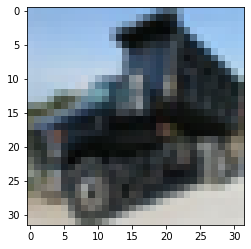

In [33]:
for image, label in test_dataset.take(1):
  plt.imshow(image[0])
  plt.show()

In [34]:
pred = model.predict_generator(test_dataset.take(1))

Instructions for updating:
Please use Model.predict, which supports generators.


In [35]:
pred.shape

(32, 10)

In [36]:
image, label = next(iter(test_dataset))

In [37]:
image.shape

TensorShape([32, 32, 32, 3])

In [38]:
evals = model.evaluate(image, label)

1/1 [==============================] - 0s 1ms/step - loss: 2.3116 - accuracy: 0.1562


In [39]:
evals

[2.311568260192871, 0.15625]